In [1]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from joblib import Parallel, delayed

from ucimlrepo import fetch_ucirepo 
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

display_pca = False

# Overall function definitions

In [24]:
class InstanceSelectionProblem(Problem):
	n_neighbors = 5
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=3,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		f3 = Parallel(n_jobs=-1)(delayed(self.calculate_instance_IR)(instance) for instance in x)
		
		out["F"] = np.column_stack([f1, f2, f3])

	def calculate_instance_IR(self, instance):
		num_1_class = np.sum(self.y_train[instance])
		num_0_class = self.n_instances - num_1_class
		IR = max(num_0_class, num_1_class) / min(num_0_class, num_1_class)
		return IR

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= InstanceSelectionProblem.n_neighbors:
			optimization_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1


def split_and_scale_datasets(X, y, split_1=0.5, split_2=0.5, random_state=42, scale=True):
	X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_1, random_state=random_state, stratify=y)
	X_val, X_test, y_val, y_test =  train_test_split(X_temp, y_temp, test_size=split_2, random_state=random_state, stratify=y_temp)

	if scale:
		scaler = StandardScaler()
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)
		X_val = scaler.transform(X_val)

	return X_train, X_val, X_test, y_train, y_val, y_test

def set_summary(dataset, set_name):

	if "x" in set_name.lower():
		num_examples = dataset.shape[0]
		num_features = dataset.shape[1]

		print(f"\nSummary for set {set_name}")
		print(f"\t- Num examples: {num_examples}")
		print(f"\t- Num features: {num_features}")

	if "y" in set_name:
		counts = pd.DataFrame(dataset).value_counts()
		class_0_count = counts[0]
		class_1_count = counts[1]

		majority_class = max(class_0_count, class_1_count)
		minority_class = min(class_0_count, class_1_count)

		majority_class_name = 0 if majority_class == class_0_count else class_1_count

		print(f"\nSummary for set {set_name}")
		print(f"\t- Number of examples in class 0: {class_0_count}")
		print(f"\t- Number of examples in class 1: {class_1_count}")
		print(f"\t- Total number of examples: {class_0_count + class_1_count}")
		print(f"\t- Imbalance ratio: {round(majority_class/minority_class, 4)} (Majority class is {majority_class_name})")		

def generate_PCA(X, y, plot_title):
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)
	plt.figure(figsize=(8, 6))
	plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k')
	plt.title(plot_title)
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	return X_pca, pca


# Generic Cancer KNN dataset - Kaggle


-----------------------------------
Baseline: 0.972027972027972
Optimize: 0.972027972027972

Summary for set y
	- Number of examples in class 0: 146
	- Number of examples in class 1: 138
	- Total number of examples: 284
	- Imbalance ratio: 1.058 (Majority class is 0)
None
(138, 30)
-----------------------------------



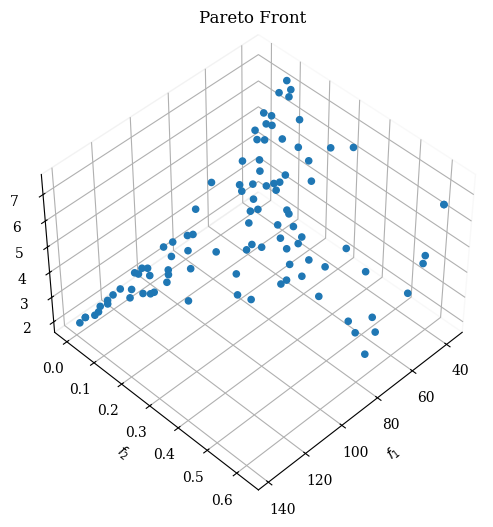

In [30]:
# Load the dataset
df = pd.read_csv("KNNAlgorithmDataset.csv")
df = df.drop(columns='id')
df = df.drop(columns='Unnamed: 32')
X = df.drop(columns='diagnosis')
y = df['diagnosis']

# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

# Determine baseline accuracy of classifier on all examples
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
baseline_test_acc = accuracy_score(y_test, y_pred)

# Run GA optimization
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

# Plot the first pareto front
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

# Calculate the test accuracy using the best instance
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
optimized_test_acc = accuracy_score(y_test, y_pred)

print(f"\n-----------------------------------")
print(f"Baseline: {baseline_test_acc}")
print(f"Optimize: {optimized_test_acc}")
print(set_summary(best_solution, "y"))
print(x_train_filtered.shape)
print(f"-----------------------------------\n")

# Plot PCA of the test set highlighting the selected instance examples
if display_pca:
	selected_indices_idx = []
	for row in x_train_filtered:
		selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
	x_train_selections = X_train[selected_indices_idx]

	X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
	X_train_pca = pca.transform(x_train_filtered)
	plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
	plt.show()

# Glass1 - KEEL (Working)

C:\Users\RjKim\AppData\Local\Temp\ipykernel_4868\3779685379.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')


Test accuracy: 0.7407407407407407
Test accuracy using best instance 0.6851851851851852


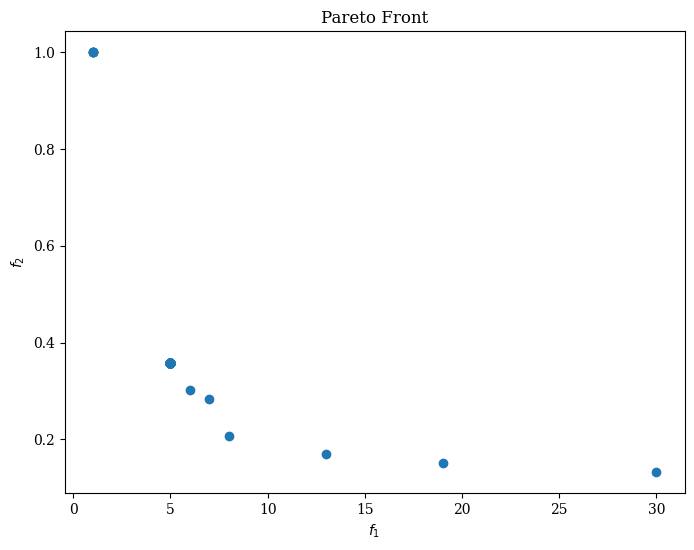

In [ ]:
# Load the dataset
df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')
X = df.drop(columns='Class')
y = df['Class']

# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

# Determine baseline accuracy of classifier on all examples
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
baseline_test_acc = accuracy_score(y_test, y_pred)

# Run optimization on training set, using validation metrics
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

# Display first pareto front
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

# Calculate the test accuracy using the best solution result from GA optimization
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
optimized_test_acc = accuracy_score(y_test, y_pred)

print(f"\n-----------------------------------")
print(f"Baseline: {baseline_test_acc}")
print(f"Optimize: {optimized_test_acc}")
print(set_summary(best_solution, "y"))
print(x_train_filtered.shape)
print(f"-----------------------------------\n")

# Generate PCA of the test set, and highlight training set instance which yields best performance
if display_pca:
	selected_indices_idx = []
	for row in x_train_filtered:
		selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
	x_train_selections = X_train[selected_indices_idx]

	X_pca, pca = generate_PCA(X_test, y_test, 'PCA of test set with best instances overlayed')
	X_train_pca = pca.transform(x_train_filtered)
	plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='r')
	plt.show()

# Pima - KEEL (Working)

Test accuracy: 0.7135416666666666
Test accuracy using best instance 0.6822916666666666


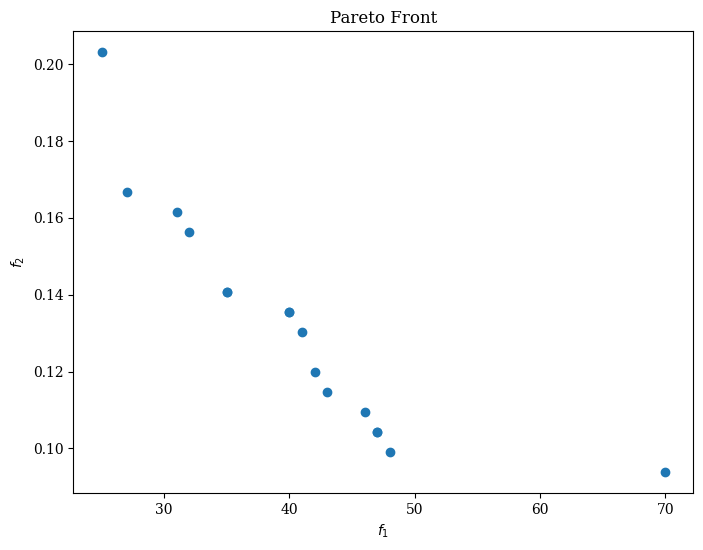

In [5]:
# Read dataset
df = pd.read_csv("Datasets/pima/pima.csv", delimiter=',')
X = df.drop(columns='Diabetic')
y = df['Diabetic']

# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

# Calcuate baseline test accuracy
baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
baseline_knn.fit(X_train, y_train)
y_pred = baseline_knn.predict(X_test)
baseline_test_acc = accuracy_score(y_test, y_pred)

# Run GA optimization
problem = InstanceSelectionProblem(X_train, y_train, X_val, y_val)
algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

# Display first pareto front
plot = Scatter(title="Pareto Front")
plot.add(res.F, label="Pareto-optimal solutions")
plot.show()
best_solution = res.X[0]

# Calculate test accuracy using best set
x_train_filtered, y_train_filtered = X_train[best_solution], y_train[best_solution]
final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem.n_neighbors)
final_test_knn.fit(x_train_filtered, y_train_filtered)
y_pred = final_test_knn.predict(X_test)
optimized_test_acc = accuracy_score(y_test, y_pred)

# Generate PCA of the test set, and highlight training set instance which yields best performance
if display_pca:
	selected_indices_idx = []
	for row in x_train_filtered:
		selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
	x_train_selections = X_train[selected_indices_idx]

	X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
	X_train_pca = pca.transform(x_train_filtered)
	plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
	plt.show()